In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from datetime import datetime

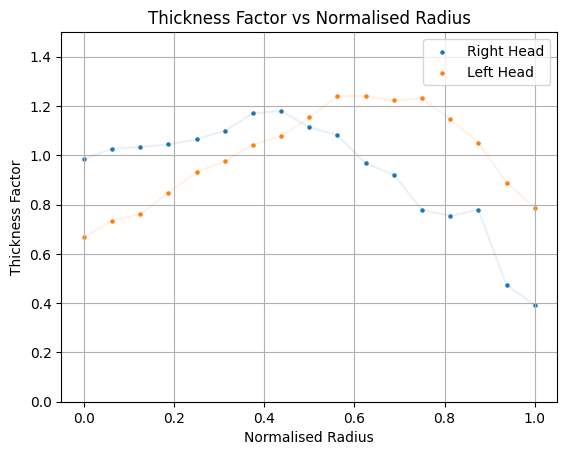

In [14]:
# Import data
df = pd.read_csv('data/plasma/PS0589.csv') # Right head
dfnp1 = df.to_numpy()
df = pd.read_csv('data/plasma/PS0592.csv') # Left head
dfnp2 = df.to_numpy()

if not np.array_equal(dfnp1[:,0], dfnp2[:,0]):
    raise ValueError('Radii do not match')
radii = dfnp1[:,0]
MAX_RADIUS = np.max(radii)

# Normalise radii
radii_norm = radii / MAX_RADIUS
thickness_factors1 = dfnp1[:,1]
thickness_factors2 = dfnp2[:,1]

# Extract pitch and roll
pitch1 = dfnp1[:,2][0]
pitch2 = dfnp2[:,2][0]
roll1 = dfnp1[:,3][0]
roll2 = dfnp2[:,3][0]

# Plot data
plt.scatter(radii_norm, thickness_factors1, label='Right Head', s=5)
plt.scatter(radii_norm, thickness_factors2, label='Left Head', s=5)
plt.plot(radii_norm, thickness_factors1, alpha=0.1)
plt.plot(radii_norm, thickness_factors2, alpha=0.1)
plt.xlabel('Normalised Radius')
plt.ylabel('Thickness Factor')
plt.title('Thickness Factor vs Normalised Radius')
plt.ylim(0, 1.5)
plt.legend()
plt.grid()
plt.show()


#### Fit the data

In [16]:
X_train = []
for i in range(len(radii_norm)):
    X_train += [[radii_norm[i], pitch1, roll1]]
for i in range(len(radii_norm)):
    X_train += [[radii_norm[i], pitch2, roll2]]
X_train = np.array(X_train)
print(f'X_train.shape = {X_train.shape}')

y_train = np.append(thickness_factors1, thickness_factors2)
print(f'y_train.shape = {y_train.shape}')

X_train.shape = (34, 3)
y_train.shape = (34,)


In [60]:
# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='gelu', input_shape=(3,)),
    tf.keras.layers.Dense(32, activation='gelu'),
    tf.keras.layers.Dense(1, activation='linear')
])

# Compile the model
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 128)               512       
                                                                 
 dense_34 (Dense)            (None, 32)                4128      
                                                                 
 dense_35 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4,673
Trainable params: 4,673
Non-trainable params: 0
_________________________________________________________________


In [61]:
# Train the model
history = model.fit(X_train, y_train, epochs=17500, verbose=0)

In [63]:
# Save the model
optional_desc = ''
dt = datetime.now().strftime('%y%m%d-%H%M')
if optional_desc == '':
    optional_desc = 'model'
model_path = f'models/plasma/{optional_desc}-{dt}.h5'
model.save(model_path)

50/50 [==============================] - 0s 614us/step
[[0.980828  ]
 [0.9812744 ]
 [0.98171914]
 ...
 [0.40902847]
 [0.40742373]
 [0.4058153 ]]


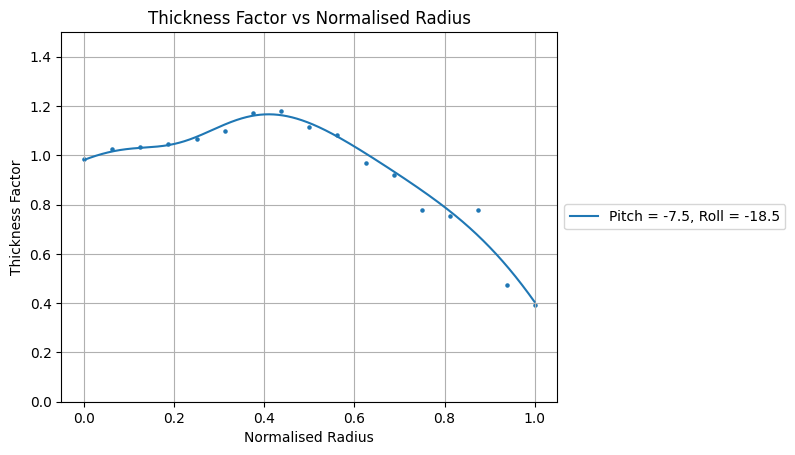

50/50 [==============================] - 0s 755us/step
[[0.6876808 ]
 [0.6880984 ]
 [0.6885168 ]
 ...
 [0.77964234]
 [0.7781562 ]
 [0.77666855]]


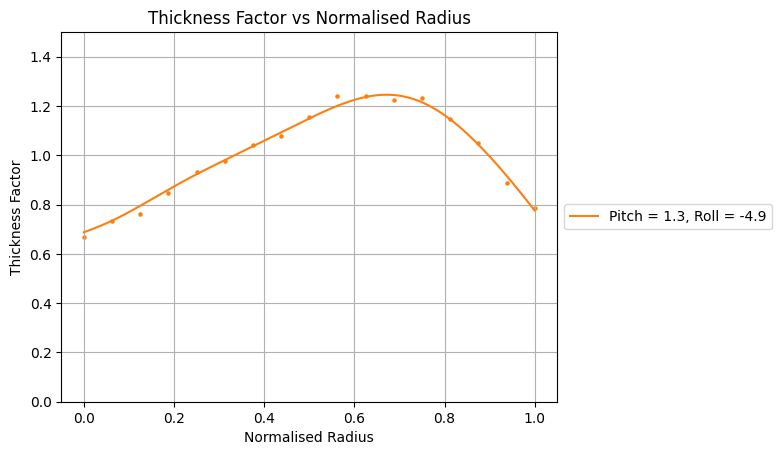

In [62]:
def plot_trained(pitch, roll, color=None):

    radii_ls = np.arange(0, 160, 0.1)/MAX_RADIUS
    pitch_ls = np.full_like(radii_ls, pitch)
    roll_ls = np.full_like(radii_ls, roll)

    X_test = np.column_stack((radii_ls, pitch_ls, roll_ls))
    y_test = model.predict(X_test)

    print(y_test)

    label = f'Pitch = {pitch}, Roll = {roll}'
    plt.plot(X_test[:, 0], y_test, color=color, label=label)

# Plot the results
plot_trained(pitch1, roll1, color='C0')
plt.scatter(radii_norm, thickness_factors1, s=5, color='C0')
plt.xlabel('Normalised Radius')
plt.ylabel('Thickness Factor')
plt.title('Thickness Factor vs Normalised Radius')
plt.ylim(0, 1.5)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.show()

plot_trained(pitch2, roll2, color='C1')
plt.scatter(radii_norm, thickness_factors2, s=5, color='C1')
plt.xlabel('Normalised Radius')
plt.ylabel('Thickness Factor')
plt.title('Thickness Factor vs Normalised Radius')
plt.ylim(0, 1.5)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.show()
